<a href="https://colab.research.google.com/github/Anteii/HPC-Labs/blob/main/lab1/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from IPython.display import clear_output

In [2]:
#!apt-get --purge remove cuda nvidia* libnvidia-*
#!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
#!apt-get remove cuda-*
#!apt autoremove
#!apt-get update

#clear_output()

In [3]:
#!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
#!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
#!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
#!apt-get update
#!apt-get install cuda-9.2

In [13]:
!nvidia-smi

Fri Oct  7 18:08:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
!git clone https://github.com/NVIDIA/cuda-samples.git
!make -C /content/cuda-samples/Samples/1_Utilities/deviceQuery
clear_output()
!/content/cuda-samples/bin/x86_64/linux/release/deviceQuery

/content/cuda-samples/bin/x86_64/linux/release/deviceQuery Starting...

 CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "Tesla T4"
  CUDA Driver Version / Runtime Version          11.2 / 11.2
  CUDA Capability Major/Minor version number:    7.5
  Total amount of global memory:                 15110 MBytes (15843721216 bytes)
  (040) Multiprocessors, (064) CUDA Cores/MP:    2560 CUDA Cores
  GPU Max Clock rate:                            1590 MHz (1.59 GHz)
  Memory Clock rate:                             5001 Mhz
  Memory Bus Width:                              256-bit
  L2 Cache Size:                                 4194304 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
  Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
  Total amount of constant memory:    

In [6]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


# Test program

In [7]:
%%cu
#include <iostream>
int main()
{
    std::cout << "Hello World!\n";
    return 0;
}

Hello World!



# Matrix Multiplication

In [ ]:
%%cu
#include <cstdio>
#include <iostream>
#include <ctime>
#include "assert.h"
using namespace std;


__global__ void matMulKernel(int* mat1, int* mat2, int* res, int N, int M, int K){
     int row = blockIdx.y * blockDim.y + threadIdx.y;
     int col = blockIdx.x * blockDim.x + threadIdx.x;

     if (row < N && col < K){
         res[row * K + col] = 0;
         for (int i = 0; i < M; ++i) {
            res[row * K + col] += mat1[row * M + i] * mat2[i * K + col];
        }
     }
}

float cpuMatMul(int* mat1, int* mat2, int* res, int N, int M, int K){
    
    clock_t start, end;

    start = clock();

    for (int i = 0; i < N; ++i){
        for (int j = 0; j < K; ++j){
            int t = 0;
            for (int k = 0; k < M; ++k){
                t += mat1[i * M + k] * mat2[k * K + j];
            }
            res[i * K + j] = t;
        } 
    }

    end = clock();
    
    return 1.0f * (end - start) / CLOCKS_PER_SEC;
}

void printMatrix(int* mat, int N, int M){
    for (int i = 0; i < N; ++i){
        for (int j = 0; j < M; ++j){
            cout << mat[i * M + j] << " ";
        }
        cout << endl;
    }
}

void randomFillCPU(int* mat, int N, int M, float scale = 1, float bias = 0, int mod = RAND_MAX){
  for (int i = 0; i < N * M; ++i){
      mat[i] = int(scale * (rand() % mod) + bias);
  }
}

void checkError(cudaError_t error){
	if (error != cudaSuccess){
		cout << "Error" << endl;
		cerr << cudaGetErrorString(error) << endl;
		exit(1);
	}
}

float gpuMatMul(int* mat1, int* mat2, int* res, int N, int M, int K){

    // Declare needed variables
    int mat1_size = N * M * sizeof(int);
    int mat2_size = M * K * sizeof(int);
    int res_size = N * K * sizeof(int);

    int* mat1_dev;
    int* mat2_dev;
    int* res_dev;

    float start, end, totalTime;
	  cudaEvent_t startEvent, stopEvent;

		// Allocate memory on device
		checkError(cudaMalloc(&mat1_dev, mat1_size));
		checkError(cudaMalloc(&mat2_dev, mat2_size));
		checkError(cudaMalloc(&res_dev, res_size));

    // Copy mat1 and mat2 from host to device
    checkError(cudaMemcpy(mat1_dev, mat1, mat1_size, cudaMemcpyHostToDevice)); 
    checkError(cudaMemcpy(mat2_dev, mat2, mat2_size, cudaMemcpyHostToDevice));

    // Create events for fixing time
    checkError(cudaEventCreate(&startEvent));
	  checkError(cudaEventCreate(&stopEvent));

    // Create threads and blocks topography
    dim3 blockDim(32, 32, 1);
    
    int gx = (K - 1) / blockDim.x + 1;
    int gy = (N - 1) / blockDim.y + 1;
     
    dim3 gridDim(gx, gy, 1); // Don't need to write z = 1

    // Write down current time
    checkError(cudaEventRecord(startEvent, 0));

    // Multiplicate matricies
    matMulKernel<<<gridDim, blockDim>>>(mat1_dev, mat2_dev, res_dev, N, M, K);

    // Write down current time
    checkError(cudaEventRecord(stopEvent, 0));
	
    // Synchronize device
    checkError(cudaDeviceSynchronize());

    // Calculate and print elapsed time
    checkError(cudaEventElapsedTime(&totalTime, startEvent, stopEvent));

    // Copy result from device to host
    checkError(cudaMemcpy(res, res_dev, res_size, cudaMemcpyDeviceToHost));

    // Free device memory
    cudaFree(mat1_dev);
    cudaFree(mat2_dev);
    cudaFree(res_dev);

    // in seconds
    return totalTime / 1000;
}

bool checkEquality(int* mat1, int* mat2, int N){
	bool flag = true;
	
	for (int i = 0; i < N; ++i){
      if (mat1[i] != mat2[i]){
          flag = false;
          break;
      }
  }

  return flag;
}

void experiment(int N, int M, int K, int repeats, 
                float* cpuTime, float* gpuTime){
    
    *cpuTime = 0;
    *gpuTime = 0;

    int* mat1 = (int*)malloc(N * M * sizeof(int));
    int* mat2 = (int*)malloc(M * K * sizeof(int));
    int* gpu_res = (int*)malloc(N * K * sizeof(int));
    int* cpu_res = (int*)malloc(N * K * sizeof(int));

    for (int repeat = 0; repeat < repeats; ++repeat){
        randomFillCPU(mat1, N, M, 1, 0, 64);
        randomFillCPU(mat2, M, K, 1, 0, 64);

        *cpuTime += cpuMatMul(mat1, mat2, cpu_res, N, M, K);
        *gpuTime += gpuMatMul(mat1, mat2, gpu_res, N, M, K);
        
        assert(checkEquality(cpu_res, gpu_res, N * K));
    }
    
    *cpuTime /= repeats;
    *gpuTime /= repeats;

    cout << "CPU Time: " << *cpuTime << endl;
    cout << "GPU Time: " << *gpuTime << endl;
    
    free(mat1);
    free(mat2);
    free(gpu_res);
    free(cpu_res);
}


int main(){
  srand(42);

  // N is a height of the first matrix
  // M is a width of the first matrix and height of the second matrix
  // K is a height of the second matrix

  int N, M, K;

  int expNum = 40;
  int nRuns = 4;

  int* paramN = new int[expNum];
  int* paramM = new int[expNum];
  int* paramK = new int[expNum];
  float* paramCpuTime = new float[expNum];
  float* paramGpuTime = new float[expNum];


  for (int i = 0; i < expNum; ++i){
      
      paramN[i] = (100 + rand()) % 2000;
      paramM[i] = (100 + rand()) % 2000;
      paramK[i] = (100 + rand()) % 2000;

      //paramN[i] = paramM[i] = paramK[i] = (100 + rand()) % 2000;
      //paramN[i] = paramM[i] = paramK[i] = 10 * (1 << i);

      cout << "N = " << paramN[i] << " M = " << paramM[i] << " K = " << paramK[i] << endl;
      experiment(paramN[i], paramM[i], paramK[i], nRuns, 
                 paramCpuTime + i, paramGpuTime + i);
  }

  // For easy conversion to python
  cout << endl;
  cout << "N: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramN[i] << " ";
  }
  cout << endl;

  cout << "M: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramM[i] << " ";
  }
  cout << endl;

  cout << "K: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramK[i] << " ";
  }
  cout << endl;

  cout << "cpuTime: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramCpuTime[i] << " ";
  }
  cout << endl;

  cout << "gpuTime: ";
  for (int i = 0; i < expNum; ++i){
      cout << paramGpuTime[i] << " ";
  }

  cout << endl;

  return 0;
}

# Visualization

Про выбор конфигурации сетки
https://events.prace-ri.eu/event/477/sessions/1420/attachments/391/580/CUDA_MM.pdf

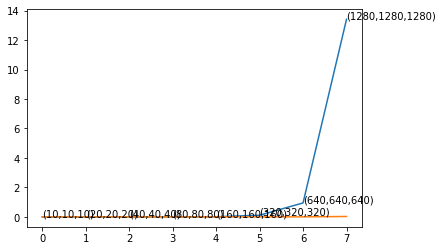

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

params = {
    "N": "10 20 40 80 160 320 640 1280",
    "M": "10 20 40 80 160 320 640 1280",
    "K": "10 20 40 80 160 320 640 1280",
    "cpuTime": "4.25e-06 2.525e-05 0.0001835 0.0013995 0.011212 0.114941 0.948382 13.4131",
    "gpuTime": "1.4568e-05 1.6696e-05 2.4728e-05 3.908e-05 9.0032e-05 0.000464648 0.00307926 0.0299518",
}

for key in ["M", "N", "K"]:
  params[key] = np.array(list(map(int, params[key].split())))
for key in ["cpuTime", "gpuTime"]:
  params[key] = np.array(list(map(float, params[key].split())))

expNum = len(params["N"])

_, ax = plt.subplots()

sns.lineplot(x=range(expNum), y=params["cpuTime"], ax=ax)
sns.lineplot(x=range(expNum), y=params["gpuTime"], ax=ax)

for i in range(expNum):
  ax.text(i, params['cpuTime'][i], f"({params['N'][i]},{params['M'][i]},{params['K'][i]})")

## Square matrices

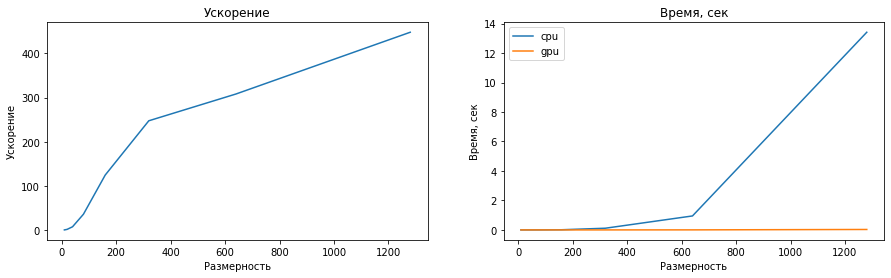

In [12]:
N, gpu_time = zip(*sorted(zip(params["N"], params["gpuTime"])))
N, cpu_time = zip(*sorted(zip(params["N"], params["cpuTime"])))

N, cpu_time, gpu_time = np.array(N), np.array(cpu_time), np.array(gpu_time)

speed_up = cpu_time / gpu_time

fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

axs[0].set_title("Ускорение")
axs[0].set_xlabel("Размерность")
axs[0].set_ylabel("Ускорение")
sns.lineplot(x=N, y=speed_up, ax=axs[0])


axs[1].set_title("Время, сек")
axs[1].set_xlabel("Размерность")
axs[1].set_ylabel("Время, сек")

sns.lineplot(x=N, y=cpu_time, ax=axs[1], label="cpu")
sns.lineplot(x=N, y=gpu_time, ax=axs[1], label="gpu");

## Recatangular matrices

Credits for display code: https://stackoverflow.com/questions/14995610/how-to-make-a-4d-plot-with-matplotlib-using-arbitrary-data

RuntimeError: ignored

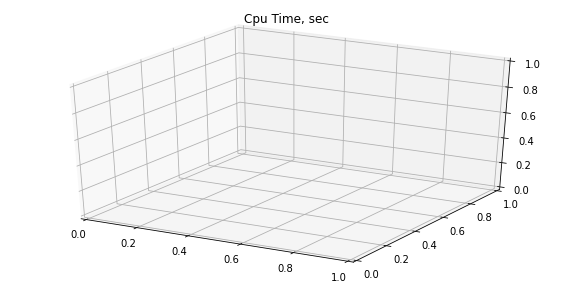

In [92]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

def plot4d(n, m, k, times, ax, cmap = "seismic"):

  triangles = mtri.Triangulation(n, m).triangles;

  colors = np.mean([
      times[triangles[:,0]], 
      times[triangles[:,1]], 
      times[triangles[:,2]]
  ], axis = 0);

  triang = mtri.Triangulation(n, m, triangles);
  surf = ax.plot_trisurf(triang, k, cmap = cmap, shade=False, linewidth=0.2);
  surf.set_array(colors); 
  surf.autoscale();

  cbar = fig.colorbar(surf, shrink=0.5, aspect=5);
  cbar.ax.get_yaxis().labelpad = 15; 
  
  cbar.ax.set_ylabel("Time", rotation = 270);
  ax.set_xlabel("N"); 
  ax.set_ylabel("M");
  ax.set_zlabel("K");

  #ax.invert_xaxis()

n, m, k = params["N"], params["M"], params["K"]
cpuTime, gpuTime = params["cpuTime"], params["gpuTime"]

fig = plt.figure(figsize=(22, 5));

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_title("Cpu Time, sec")
plot4d(n, m, k, cpuTime, ax, cmap="inferno")

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title("Gpu Time, sec")
plot4d(n, m, k, gpuTime, ax, cmap="inferno")

#fig.text(0.2, 0.1, "textsrt")
#fig.subplots_adjust(bottom=0.25)
plt.show();

In [97]:
mtri.Triangulation(n, m).triangles

RuntimeError: ignored

In [98]:
n

array([  10,   20,   40,   80,  160,  320,  640, 1280])

In [99]:
m

array([  10,   20,   40,   80,  160,  320,  640, 1280])